# Introduction

<img src="https://i.imgur.com/iemn4xo.jpg" width="400px">

Welcome to the "M5 Forecasting - Accuracy" competition! In this competition, contestants are challenged to forecast future sales at Walmart based on heirarchical sales in the states of California, Texas, and Wisconsin. Forecasting sales, revenue, and stock prices is a classic application of machine learning in economics, and it is important because it allows investors to make guided decisions based on forecasts made by algorithms. 

In this kernel, I will briefly explain the structure of dataset. Then, I will visualize the dataset using Matplotlib and Plotly. And finally, I will demonstrate how this problem can be approached with a variety of forecasting algorithms.

<font size=3 color="red">Please upvote this kernel if you like it. It motivates me to produce more quality content :)</font>

To get started, here is an excellent video about how to approach time series forecasting:

In [179]:
from IPython.display import HTML
HTML('<center><iframe width="700" height="400" src="https://www.youtube.com/embed/bn8rVBuIcFg?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe></center>')

# Acknowledgements

1. [M5 Forecasting - Starter Data Exploration](https://www.kaggle.com/robikscube/m5-forecasting-starter-data-exploration) ~ by Rob Mulla
2. [EDA and Baseline Model](https://www.kaggle.com/rdizzl3/eda-and-baseline-model) ~ by RDizzl3
3. [How to Create an ARIMA Model for Time Series Forecasting in Python](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) ~ by Machine Learning Mastery
4. [7 methods to perform Time Series forecasting (with Python codes)](https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/) ~ by Analytics Vidhya
5. [Economics for the IB Diploma](https://www.cambridge.org/core/books/economics-for-the-ib-diploma/1918CF16A8FC979AAB19951A487DCB1C) ~ by Ellie Tragakes
6. [Prophet](https://facebook.github.io/prophet/) ~ by Facebook

# Contents

* [<font size=4>The dataset</font>](#1)


* [<font size=4>EDA</font>](#2)
    * [Preparing the ground](#2.1)
    * [Sales data](#2.2)
    * [Denoising](#2.3)
    * [Stores and sales](#2.4)

    
* [<font size=4>Modeling</font>](#3)
    * [Train/Val split](#3.1)
    * [Naive approach](#3.2)
    * [Moving average](#3.3)
    * [Holt linear](#3.4)
    * [Exponential smoothing](#3.5)
    * [ARIMA](#3.6)
    * [Prophet](#3.7)
    * [Loss for each model](#3.8)


* [<font size=4>Takeaways</font>](#4)


* [<font size=4>Ending Note</font>](#5)

# The dataset <a id="1"></a>

The dataset consists of five .csv files.

* <code>calendar.csv</code> - Contains the dates on which products are sold. The dates are in a <code>yyyy/dd/mm</code> format.

* <code>sales_train_validation.csv</code> - Contains the historical daily unit sales data per product and store <code>[d_1 - d_1913]</code>.

* <code>submission.csv</code> - Demonstrates the correct format for submission to the competition.

* <code>sell_prices.csv</code> - Contains information about the price of the products sold per store and date.

* <code>sales_train_evaluation.csv</code> - Available one month before the competition deadline. It will include sales for <code>[d_1 - d_1941]</code>.

In this competition, we need to forecast the sales for <code>[d_1942 - d_1969]</code>. These rows form the evaluation set. The rows <code>[d_1914 - d_1941]</code> form the validation set, and the remaining rows form the training set. Now, since we understand the dataset and know what to predict, let us visualize the dataset.

In [225]:
# Link dataset
# https://www.kaggle.com/code/tarunpaparaju/m5-competition-eda-models/input

# EDA <a id="2"></a>

Now, I will try to visualize the sales data and gain some insights from it.

## Preparing the ground <a id="2.1"></a>

### Import libraries

In [180]:
# !pip install numpy pandas scikit-learn tqdm seaborn matplotlib plotly PyWavelets statsmodels scipy prophet nbformat

In [181]:
# !pip install --upgrade jupyter ipywidgets

In [182]:
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter nbextension install --py widgetsnbextension

In [183]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from prophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings("ignore")

### Load the data

In [184]:
INPUT_DIR = '.'
calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
selling_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sales_train_val = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')

## Sales data <a id="2.2"></a>


### Sample sales data

In [185]:
ids = sorted(list(set(sales_train_val['id'])))
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[2]].set_index('id')[d_cols].values[0]
x_2 = sales_train_val.loc[sales_train_val['id'] == ids[1]].set_index('id')[d_cols].values[0]
x_3 = sales_train_val.loc[sales_train_val['id'] == ids[17]].set_index('id')[d_cols].values[0]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                    mode='lines', name="First sample",
                         marker=dict(color="mediumseagreen")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
                    mode='lines', name="Second sample",
                         marker=dict(color="violet")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
                    mode='lines', name="Third sample",
                         marker=dict(color="dodgerblue")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales")
fig.show()

These are sales data from randomly selected stores in the dataset. As expected, the sales data is very erratic, owing to the fact that so many factors affect the sales on a given day. On certain days, the sales quantity is zero, which indicates that a certain product may not be available on that day (as noted by Rob in his kernel).

### Sample sales snippets

In [186]:
ids = sorted(list(set(sales_train_val['id'])))
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[0]].set_index('id')[d_cols].values[0][:90]
x_2 = sales_train_val.loc[sales_train_val['id'] == ids[4]].set_index('id')[d_cols].values[0][1300:1400]
x_3 = sales_train_val.loc[sales_train_val['id'] == ids[65]].set_index('id')[d_cols].values[0][350:450]
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                    mode='lines+markers', name="First sample",
                         marker=dict(color="mediumseagreen")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
                    mode='lines+markers', name="Second sample",
                         marker=dict(color="violet")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
                    mode='lines+markers', name="Third sample",
                         marker=dict(color="dodgerblue")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales snippets")
fig.show()

In the above plots, I simply zoom in to sample snippets in the sales data. As stated earlier, we can clearly see that the sales data is very erratic and volatile. Sometimes, the sales are zero for a few days in a row, and at other times, it remains at its peak value for a few days. Therefore, we need some sort of "denoising" techniques to find the underlying trends in the sales data and make forecasts.

## Denoising <a id="2.3"></a>

Now, I will show how these volatile sales prices can be denoised in order to extract underlying trends. This method may lose some information from the original time series, but it may be useful in extracting certain features regarding the trends in the time series.

### Wavelet denoising

Wavelet denoising (usually used with electric signals) is a way to remove the unnecessary noise from a time series. This method calculates coefficients called the "wavelet coefficients". These coefficients decide which pieces of information to keep (signal) and which ones to discard (noise).

We make use of the MAD (mean absolute deviation) value to understand the randomness in the sales and accordingly decide the minimum threshold for the wavelet coefficients in the time series. We filter out the low coefficients from the wavelets and reconstruct the sales data from the remaining coefficients and that's it; we have successfully removed noise from the sales data.

In [187]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')

In [188]:
y_w1 = denoise_signal(x_1)
y_w2 = denoise_signal(x_2)
y_w3 = denoise_signal(x_3)


fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), mode='lines+markers', y=x_1, marker=dict(color="mediumaquamarine"), showlegend=False,
               name="Original signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), y=y_w1, mode='lines', marker=dict(color="darkgreen"), showlegend=False,
               name="Denoised signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), mode='lines+markers', y=x_2, marker=dict(color="thistle"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), y=y_w2, mode='lines', marker=dict(color="purple"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), mode='lines+markers', y=x_3, marker=dict(color="lightskyblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), y=y_w3, mode='lines', marker=dict(color="navy"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Original (pale) vs. Denoised (dark) sales")
fig.show()

In the above graphs, the dark lineplots represent the denoised sales and the light lineplots represent the original sales. We can see that Wavelet denoising is able to successfully find the "general trend" in the sales data without getting distracted by the noise. Finding these high- trends or patterns in the sales may be useful in generating features to train a model.

The below diagram illustrates these graphs side-by-side. Red graphs represent original sales and green graphs represent denoised sales.

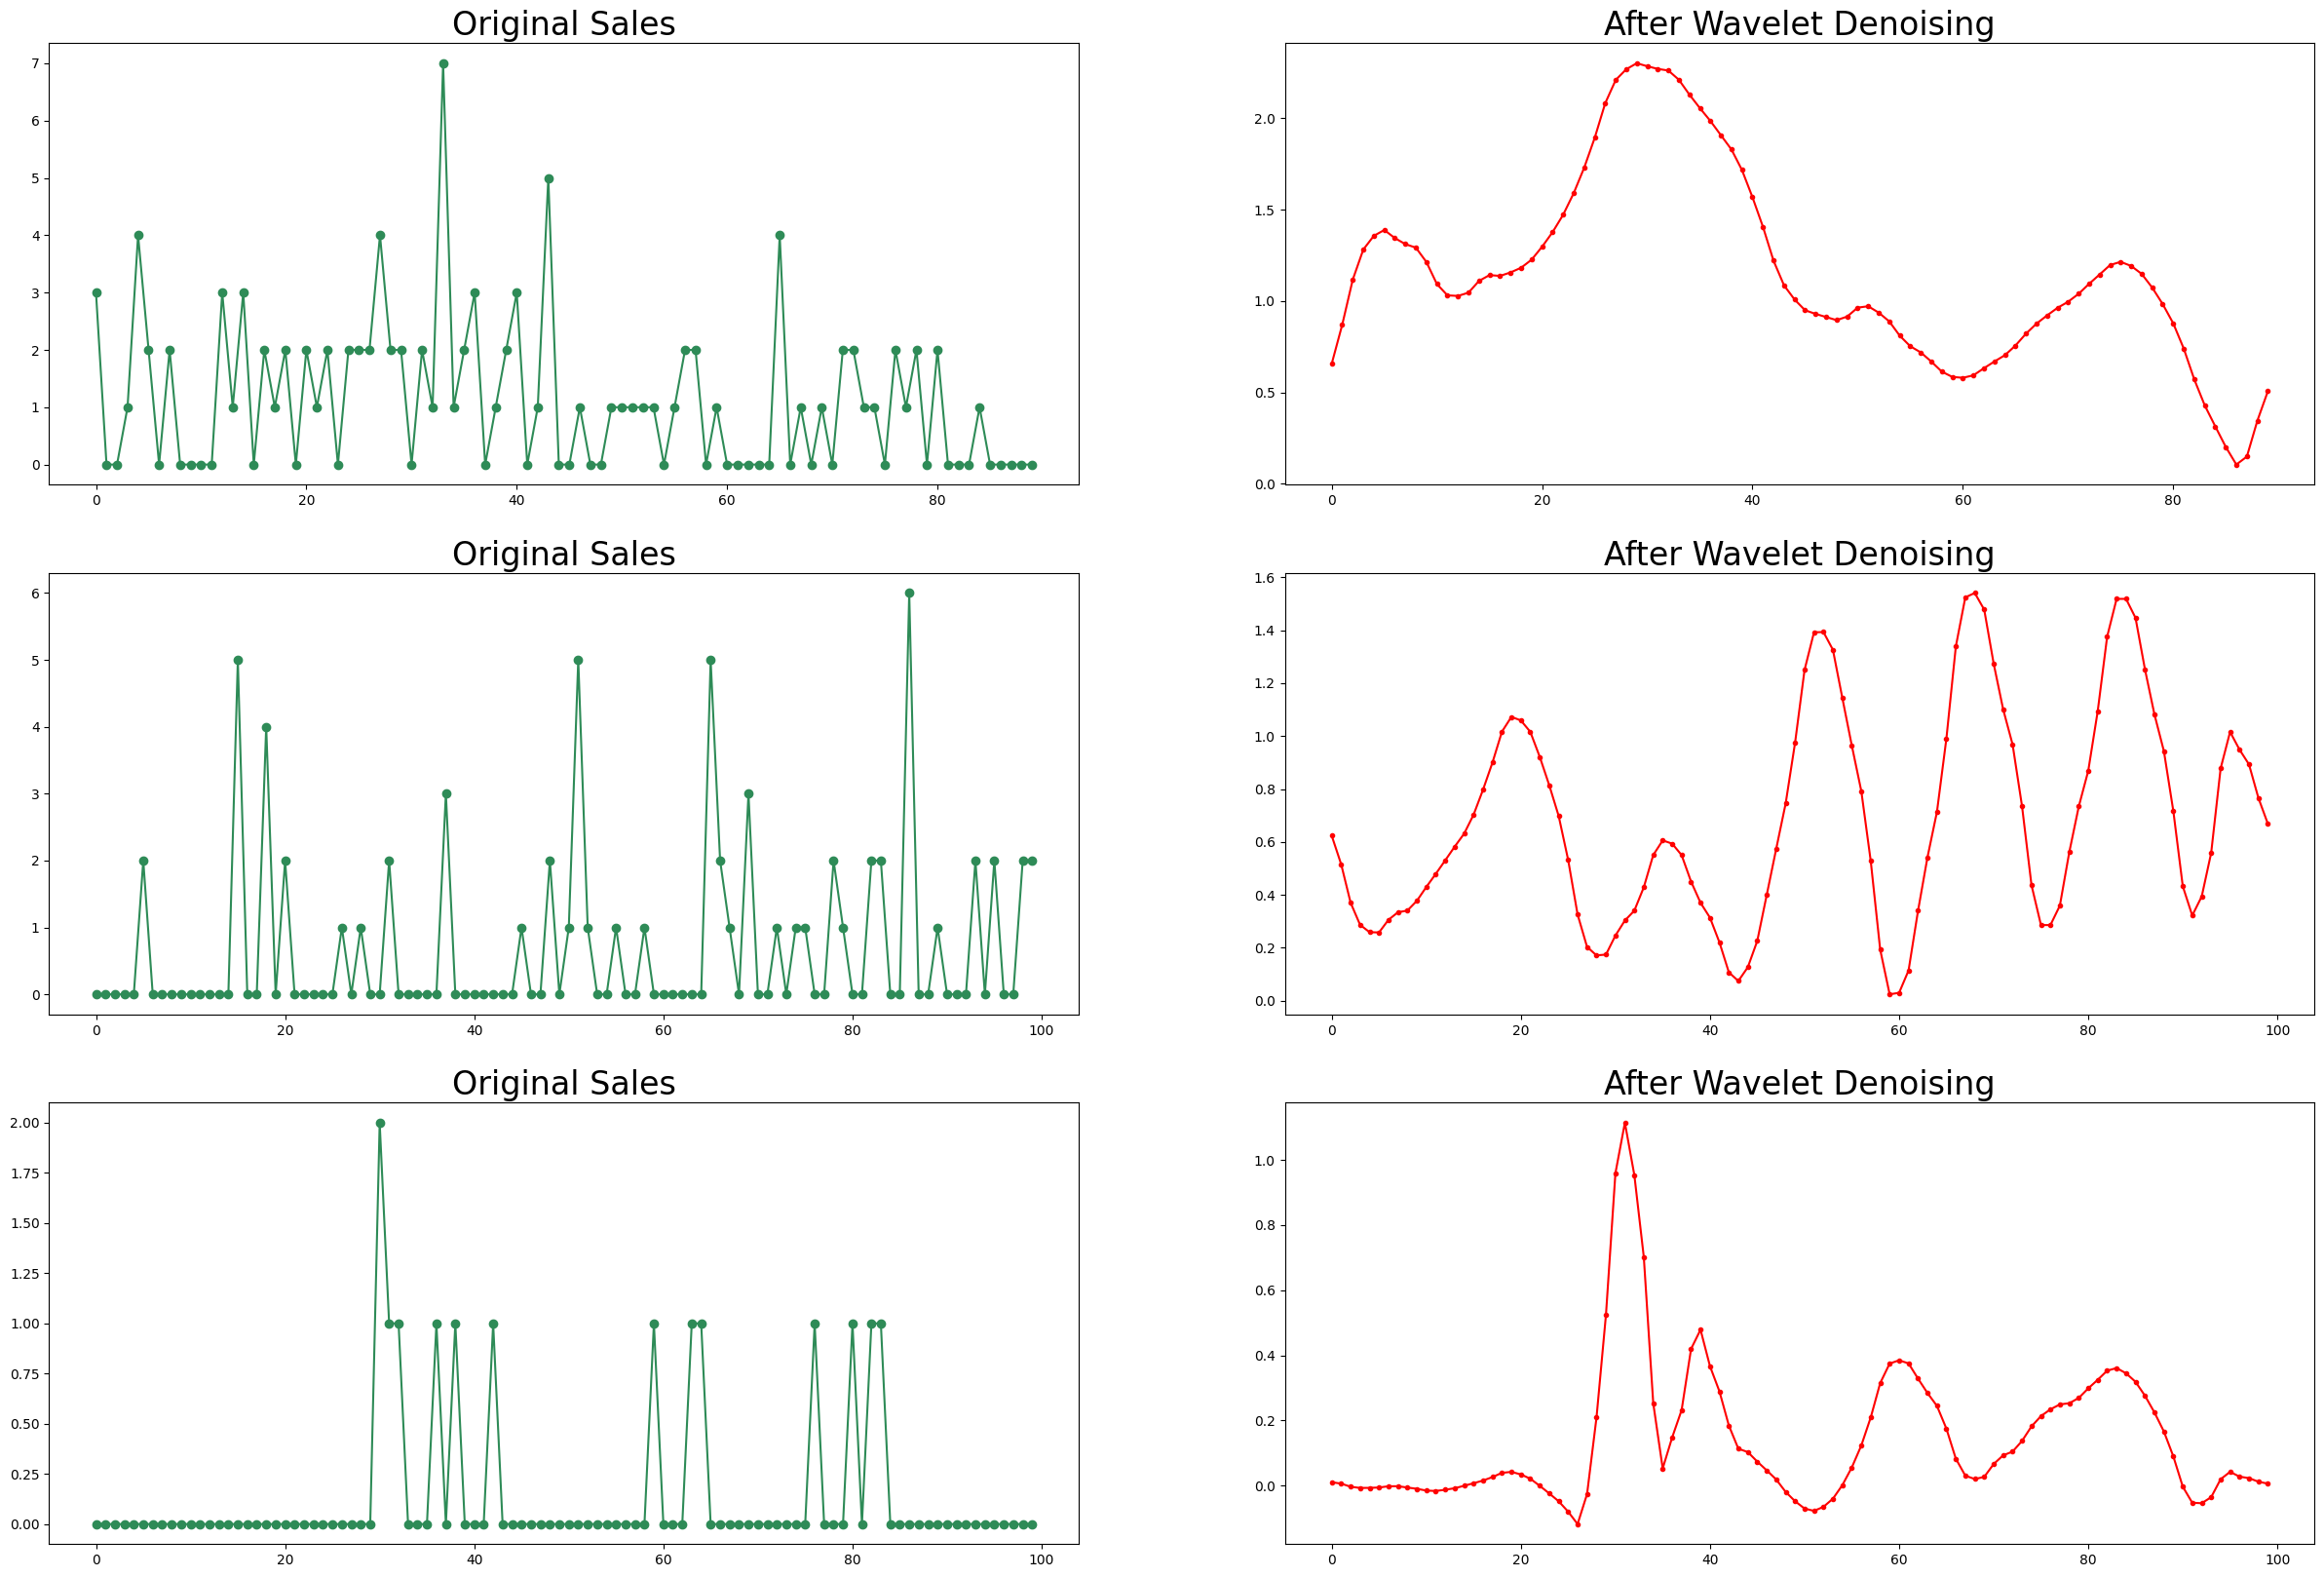

In [189]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))

ax[0, 0].plot(x_1, color='seagreen', marker='o') 
ax[0, 0].set_title('Original Sales', fontsize=24)
ax[0, 1].plot(y_w1, color='red', marker='.') 
ax[0, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[1, 0].plot(x_2, color='seagreen', marker='o') 
ax[1, 0].set_title('Original Sales', fontsize=24)
ax[1, 1].plot(y_w2, color='red', marker='.') 
ax[1, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[2, 0].plot(x_3, color='seagreen', marker='o') 
ax[2, 0].set_title('Original Sales', fontsize=24)
ax[2, 1].plot(y_w3, color='red', marker='.') 
ax[2, 1].set_title('After Wavelet Denoising', fontsize=24)

plt.show()

### Average smoothing

Average smooting is a relatively simple way to denoise time series data. In this method, we take a "window" with a fixed size (like 10). We first place the window at the beginning of the time series (first ten elements) and calculate the mean of that section. We now move the window across the time series in the forward direction by a particular "stride", calculate the mean of the new window and repeat the process, until we reach the end of the time series. All the mean values we calculated are then concatenated into a new time series, which forms the denoised sales data.

In [190]:
def average_smoothing(signal, kernel_size=3, stride=1):
    sample = []
    start = 0
    end = kernel_size
    while end <= len(signal):
        start = start + stride
        end = end + stride
        sample.extend(np.ones(end - start)*np.mean(signal[start:end]))
    return np.array(sample)

In [191]:
y_a1 = average_smoothing(x_1)
y_a2 = average_smoothing(x_2)
y_a3 = average_smoothing(x_3)

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), mode='lines+markers', y=x_1, marker=dict(color="lightskyblue"), showlegend=False,
               name="Original sales"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), y=y_a1, mode='lines', marker=dict(color="navy"), showlegend=False,
               name="Denoised sales"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), mode='lines+markers', y=x_2, marker=dict(color="thistle"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), y=y_a2, mode='lines', marker=dict(color="indigo"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), mode='lines+markers', y=x_3, marker=dict(color="mediumaquamarine"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), y=y_a3, mode='lines', marker=dict(color="darkgreen"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Original (pale) vs. Denoised (dark) signals")
fig.show()

In the above graphs, the dark lineplots represent the denoised sales and the light lineplots represent the original sales. We can see that average smoothing is not as effective as Wavelet denoising at finding macroscopic trends and pattersns in the data. A lot of the noise in the original sales persists even after denoising. Therefore, wavelet denoising is clearly more effective at finding trends in the sales data. Nonetheless, average smoothing or "rolling mean" can also be used to calculate useful features for modeling.

The below diagram illustrates these graphs side-by-side. Red graphs represent original sales and green graphs represent denoised sales.

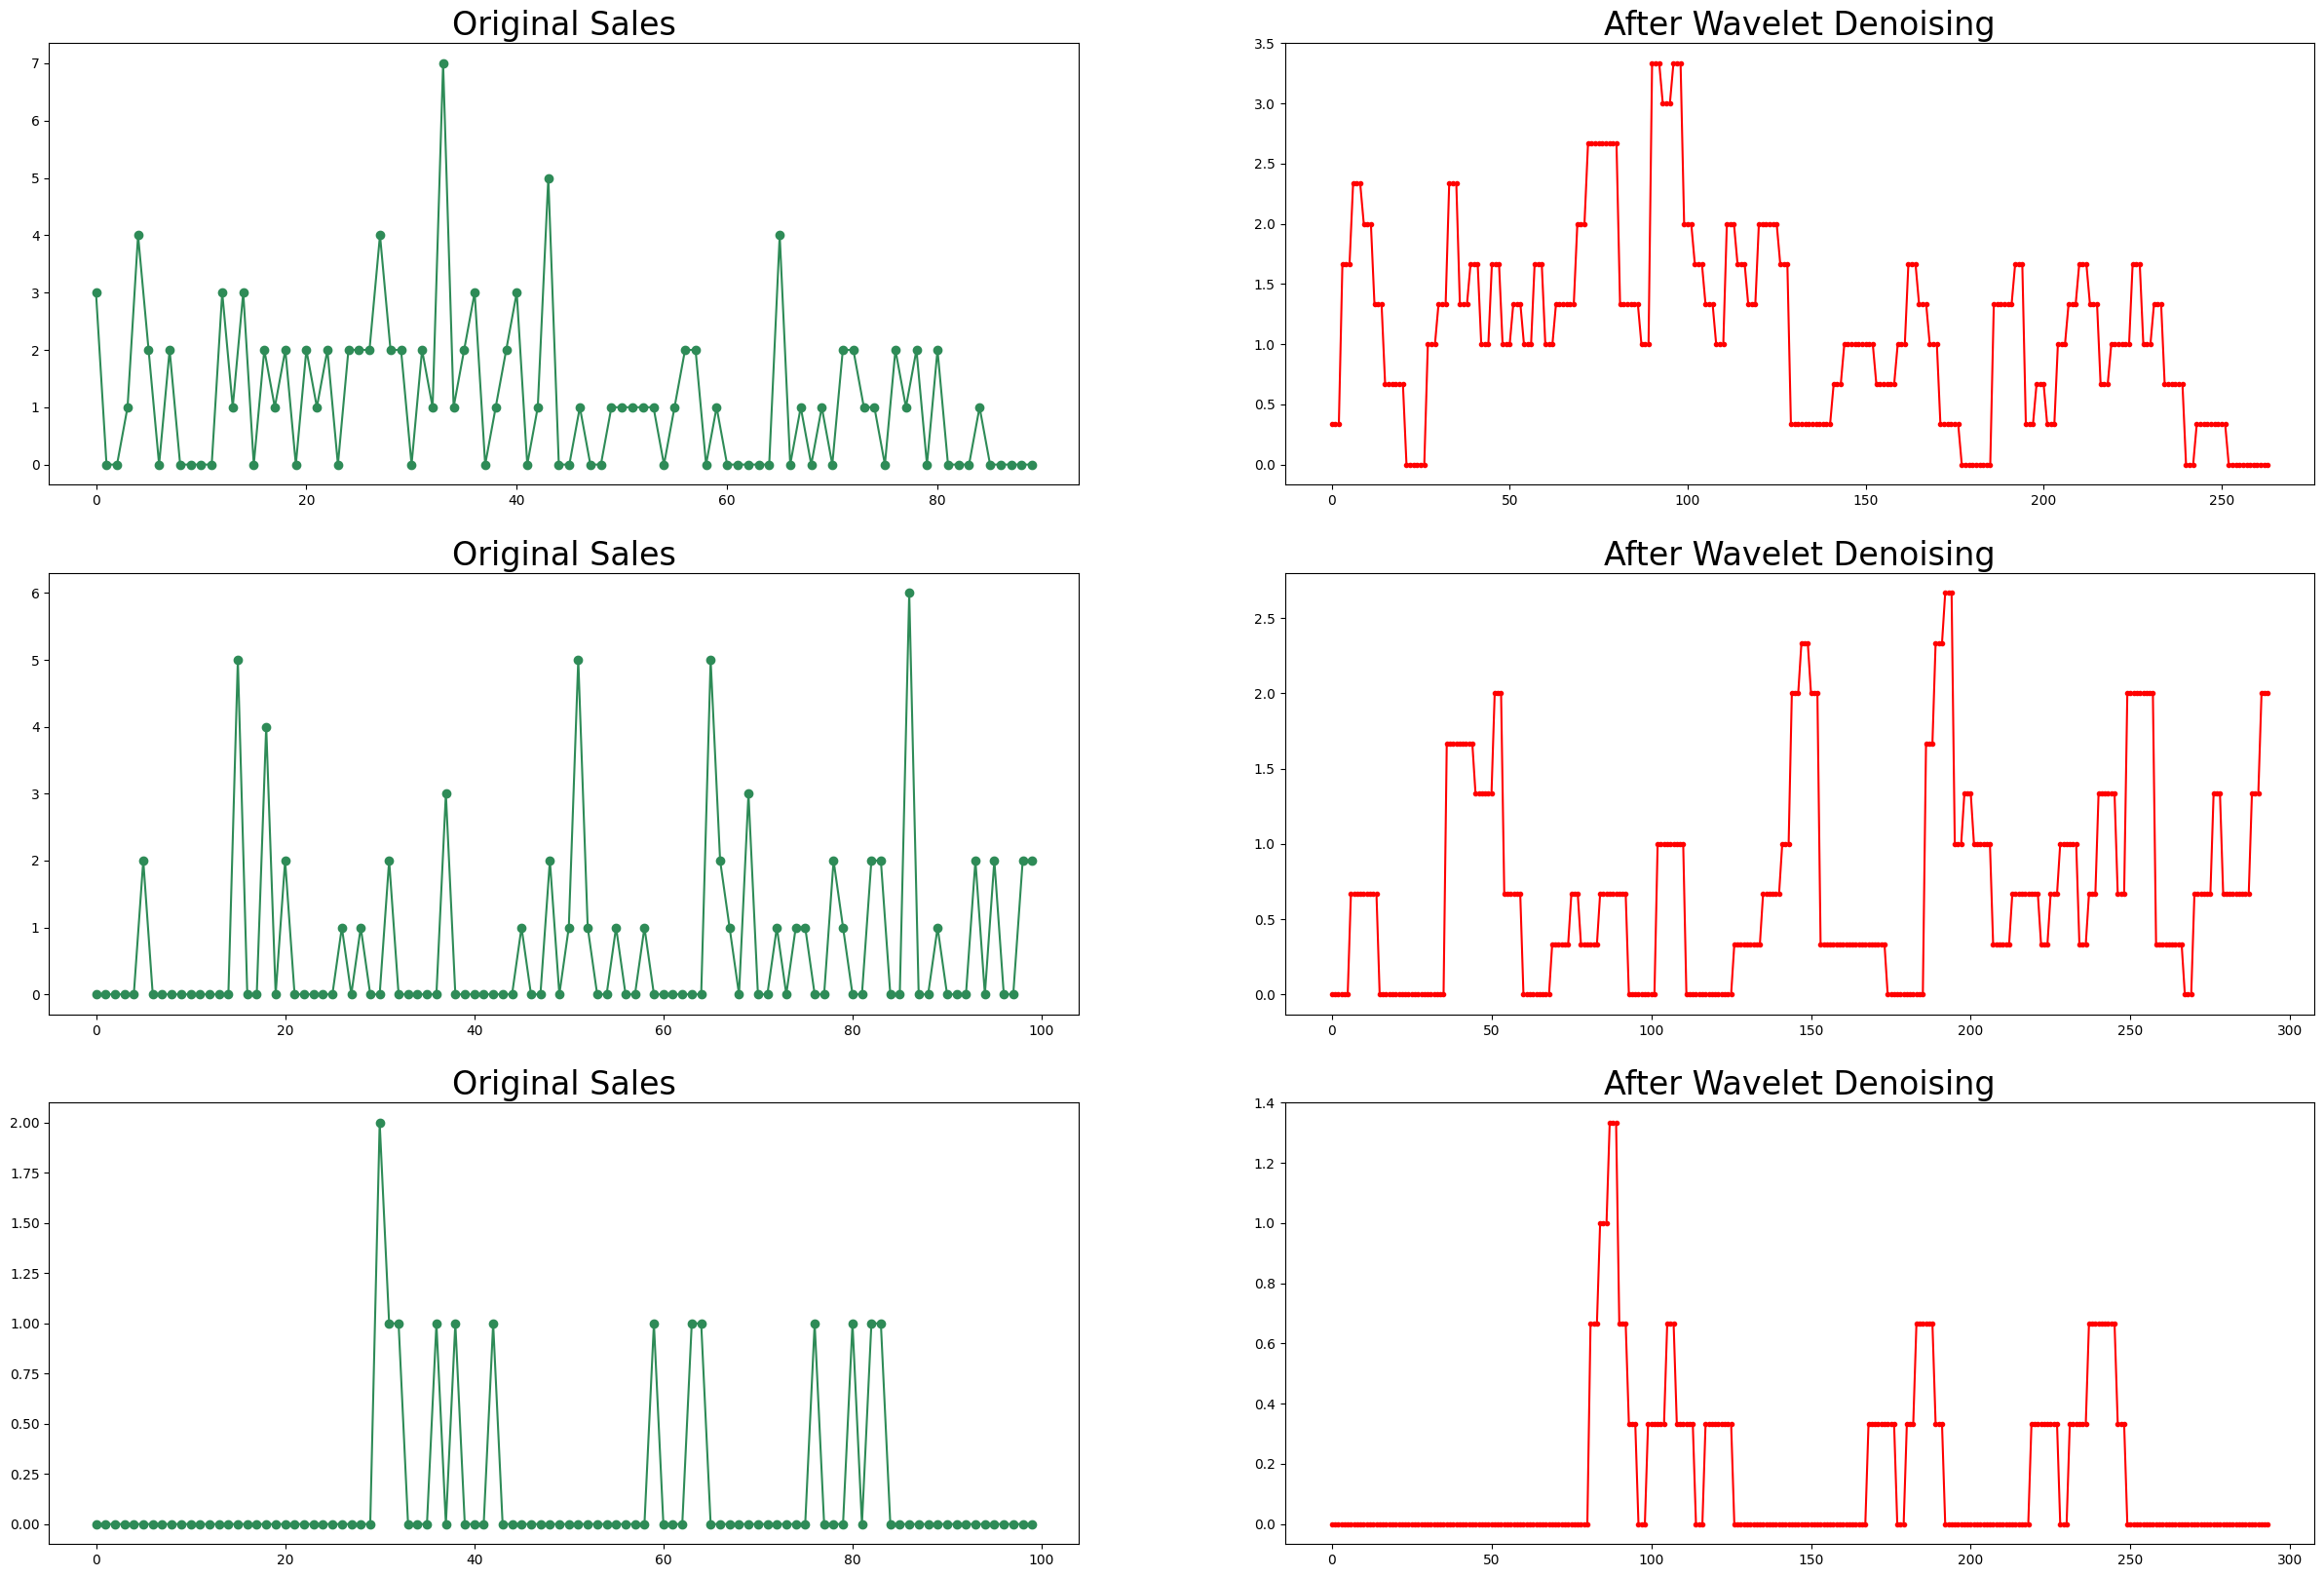

In [192]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))

ax[0, 0].plot(x_1, color='seagreen', marker='o') 
ax[0, 0].set_title('Original Sales', fontsize=24)
ax[0, 1].plot(y_a1, color='red', marker='.') 
ax[0, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[1, 0].plot(x_2, color='seagreen', marker='o') 
ax[1, 0].set_title('Original Sales', fontsize=24)
ax[1, 1].plot(y_a2, color='red', marker='.') 
ax[1, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[2, 0].plot(x_3, color='seagreen', marker='o') 
ax[2, 0].set_title('Original Sales', fontsize=24)
ax[2, 1].plot(y_a3, color='red', marker='.') 
ax[2, 1].set_title('After Wavelet Denoising', fontsize=24)

plt.show()

## Stores and states <a id="2.4"></a>

Now, I will look at the sales data across different stores and states in order to gain some useful insights.

### Rolling Average Price vs. Time for each store

In [193]:
past_sales = sales_train_val.set_index('id')[d_cols] \
    .T \
    .merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

store_list = selling_prices['store_id'].unique()
means = []
fig = go.Figure()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    means.append(np.mean(past_sales[store_items].sum(axis=1)))
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (per store)")

In the above graph, I have plotted rolling sales across all stores in the dataset. Almost every sales curve has "linear oscillation" trend at the macroscopic level. Basically, the sales oscillate like a sine wave about a certain mean value, but this mean value has an upward linear trend. This implies that the sales are oscillating at a higher and higher level every few months.

This trend is reminiscent of the **business cycle**, where economies have short-term oscillatory fluctuations but grow linearly in the long run. Maybe, such small-scale trends at the level of stores add up to decide trends we see at the macroeconomic level. Below is an illustration of the macroeconomic business cycle:

<img src="https://i.imgur.com/YB551eX.png" width="600px"> 

In [194]:
fig = go.Figure()

for i, s in enumerate(store_list):
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        fig.add_trace(go.Box(x=[s]*len(data), y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Store name ")

The above plot compares the sales distribution for each store in the dataset. The stores in California seem to have the highest variance in sales, which might indicate that some places in California grow significantly faster than others, *i.e.* there is development disparity. On the other hand, the Wisconsin and Texas sales seem to be quite consistent among themselves, without much variance. This indicates that development might be more uniform in these states. Moreover, the California stores also seem to have the highest overall mean sales.

In [195]:
df = pd.DataFrame(np.transpose([means, store_list]))
df.columns = ["Mean sales", "Store name"]
px.bar(df, y="Mean sales", x="Store name", color="Store name", title="Mean sales vs. Store name")

From the above graph, we can see the same trends: California stores have the highest variance and mean sales among all the stores in the dataset.

### Rolling Average Price vs. Time (CA)

In [196]:
greens = ["mediumaquamarine", "mediumseagreen", "seagreen", "green"]
store_list = selling_prices['store_id'].unique()
fig = go.Figure()
means = []
stores = []
for i, s in enumerate(store_list):
    if "ca" in s or "CA" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)
        fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s, marker=dict(color=greens[i])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (California)")

In the above graph, we can see the large disparity in sales among California stores. The sales curves almost never intersect each other. This may indicate that there are certain "hubs" of development in California which do not change over time. And other areas always remain behind these "hubs". The average sales in descending order are <code>CA_3, CA_1, CA_2, CA_4</code>. The store <code>CA_3</code> has maximum sales while the store <code>CA_4</code> has minimum sales. 

In [197]:
fig = go.Figure()

for i, s in enumerate(store_list):
    if "ca" in s or "CA" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        fig.add_trace(go.Box(x=[s]*len(data), y=data, name=s, marker=dict(color=greens[i])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Store name (California)")

In [198]:
df = pd.DataFrame(np.transpose([means, stores]))
df.columns = ["Mean sales", "Store name"]
px.bar(df, y="Mean sales", x="Store name", color="Store name", title="Mean sales vs. Store name", color_continuous_scale=greens)


fig = go.Figure(data=[
    go.Bar(name='', x=stores, y=means, marker={'color' : greens})])

fig.update_layout(title="Mean sales vs. Store name (California)", yaxis=dict(title="Mean sales"), xaxis=dict(title="Store name"))
fig.update_layout(barmode='group')
fig.show()

In the above plots, we can see the same relationship. The store <code>CA_3</code> has maximum sales while the store <code>CA_4</code> has minimum sales.

### Rolling Average Price vs. Time (WI)

In [199]:
purples = ["thistle", "violet", "purple", "indigo"]
store_list = selling_prices['store_id'].unique()
fig = go.Figure()
means = []
stores = []
for i, s in enumerate(store_list):
    if "wi" in s or "WI" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)
        fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s, marker=dict(color=purples[i%len(purples)])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (Wisconsin)")

In the above graph, we can see a very low disparity in sales among Wisconsin stores. The sales curves intersect each other very often. This may indicate that most parts of Wisconsin have a similar "development curve" and that there is a greater equity in development across the state. There are no specific "hotspots" or "hubs" of development. The average sales in descending order are <code>WI_2, WI_3, WI_1</code>. The store <code>WI_2</code> has maximum sales while the store <code>WI_1</code> has minimum sales. 

In [200]:
fig = go.Figure()

for i, s in enumerate(store_list):
    if "wi" in s or "WI" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        fig.add_trace(go.Box(x=[s]*len(data), y=data, name=s, marker=dict(color=purples[i%len(purples)])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Store name (Wisconsin)")

In [201]:
df = pd.DataFrame(np.transpose([means, stores]))
df.columns = ["Mean sales", "Store name"]
px.bar(df, y="Mean sales", x="Store name", color="Store name", title="Mean sales vs. Store name", color_continuous_scale=greens)


fig = go.Figure(data=[
    go.Bar(name='', x=stores, y=means, marker={'color' : purples})])

fig.update_layout(title="Mean sales vs. Store name (Wisconsin)", yaxis=dict(title="Mean sales"), xaxis=dict(title="Store name"))
fig.update_layout(barmode='group')
fig.show()

In the above plots, we can see the same relationship. The store <code>W1_2</code> has maximum sales while the store <code>W1_1</code> has minimum sales. 

### Rolling Average Price vs. Time (TX)

In [202]:
blues = ["skyblue", "dodgerblue", "darkblue"]
store_list = selling_prices['store_id'].unique()
fig = go.Figure()
means = []
stores = []
for i, s in enumerate(store_list):
    if "tx" in s or "TX" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)
        fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s, marker=dict(color=blues[i%len(blues)])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (Texas)")

In the above graph, we can once again see that a very low disparity in sales among Texas stores. The sales curves intersect each other often, albeit not as often as in Wisconsin. This might once again indicate that most parts of Texas have a similar "development curve" and that there is a greater equity in development across the state. The variance here is higher than in Wisconsin though, so there might be "hubs" of development in Texas as well, but not as pronounced as in California. The average sales in descending order are <code>TX_2, TX_3, TX_1</code>. The store <code>TX_2</code> has maximum sales while the store <code>TX_1</code> has minimum sales.

In [203]:
fig = go.Figure()

for i, s in enumerate(store_list):
    if "tx" in s or "TX" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        fig.add_trace(go.Box(x=[s]*len(data), y=data, name=s, marker=dict(color=blues[i%len(blues)])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Store name (Texas)")

In [204]:
df = pd.DataFrame(np.transpose([means, stores]))
df.columns = ["Mean sales", "Store name"]
px.bar(df, y="Mean sales", x="Store name", color="Store name", title="Mean sales vs. Store name", color_continuous_scale=greens)


fig = go.Figure(data=[
    go.Bar(name='', x=stores, y=means, marker={'color' : blues})])

fig.update_layout(title="Mean sales vs. Store name (Texas)", yaxis=dict(title="Mean sales"), xaxis=dict(title="Store name"))
fig.update_layout(barmode='group')
fig.show()

Exception ignored in: <function tqdm.__del__ at 0x0000029C997D7920>
Traceback (most recent call last):
  File "c:\Python\Python3_12\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Python\Python3_12\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In the above plots, we can see the same relationship. The store <code>TX_2</code> has maximum sales while the store <code>TX_1</code> has minimum sales. 

# Modeling <a id="3"></a>

Now, I will demonstrate how sales can be forecasted using various methods, namely: **naive approach, moving average, Holt linear, exponential smoothing, ARIMA, and Prophet**

## Train/Val split <a id="3.1"></a>

First, we need to create miniature training and validation sets to train and validate our models. I will use the last 30 days' sales as the validation data and the sales of the 70 days before that as the training data. We need to predict the sales in the validation data using the sales in the training data.

In [205]:
train_dataset = sales_train_val[d_cols[-100:-30]]
val_dataset = sales_train_val[d_cols[-30:]]

Below are the sales from three sample data points. I will use these samples to demonstrate the working of the models.

In [206]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"), showlegend=False,
               name="Original signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"), showlegend=False,
               name="Denoised signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Train (blue) vs. Validation (orange) sales")
fig.show()

## Naive approach <a id="3.2"></a>


The first approach is the very simple **naive approach**. It simply forecasts the next day's sales as the current day's sales. The model can be summarized as follows:

<img src="https://i.imgur.com/r8wjrzk.png" width="110px">

In the above equation, *y<sub>t+1</sub>* is the predicted value for the next day's sales and *y<sub>t</sub>* is today's sales. The model predicts tomorrow's sales as today's sales. Now let us see how this simple model performs on our miniature dataset. The training data is in <font color="blue">blue</font>, validation data in <font color="darkorange">orange</font>, and predictions in <font color="green">green</font>.

In [207]:
predictions = []
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(train_dataset[train_dataset.columns[-1]].values)
    else:
        predictions.append(val_dataset[val_dataset.columns[i-1]].values)
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_naive = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [208]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Naive approach")
fig.show()

We can see that the forecasts made by the naive approach are not accurate and it is to be expected of such a simple algorithm. We need more complex models which use several time stamps to make forecasts.

## Moving average <a id="3.3"></a>

The **moving average** method is more complex than the naive approach. It calculates the mean sales over the previous 30 (or any other number)  days and forecasts that as the next day's sales. This method takes the previous 30 timesteps into consideration, and is therefore less prone to short term fluctuations than the naive approach. The model can be summarized as follows:

<img src="https://i.imgur.com/5uJvt7H.png" width="200px">

In the above equation, *y<sub>t+1</sub>* is tomorrow's sales. On the right hand side, all the sales for the previous 30 days are added up and divided by 30 to find the average. This forms the model's prediction, *y<sub>t+1</sub>*. Now let us see how this new model performs on our miniature dataset. The training data is in <font color="blue">blue</font>, validation data in <font color="darkorange">orange</font>, and predictions in <font color="green">green</font>.

In [209]:
predictions = []
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(np.mean(train_dataset[train_dataset.columns[-30:]].values, axis=1))
    if i < 31 and i > 0:
        predictions.append(0.5 * (np.mean(train_dataset[train_dataset.columns[-30+i:]].values, axis=1) + \
                                  np.mean(predictions[:i], axis=0)))
    if i > 31:
        predictions.append(np.mean([predictions[:i]], axis=1))
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_avg = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [210]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Moving average")
fig.show()

We can see that this model performs better than the naive approach. It is less susceptible to the volatility in day-to-day sales data and manages to pick up trends with slightly higher accuracy. However, it is still unable to find high-level trends in the sales. 

## Holt linear <a id="3.4"></a>

The **Holt linear** is completely different from the first two methods. Holt linear attempts to capture the high-level trends in time series data using a linear function. The method can be summarized as follows:

### Forecast, level, and trend equations respectively

<img src="https://i.imgur.com/MHgcgGo.png" width="180px">
<img src="https://i.imgur.com/3ImRHEO.png" width="300px">
<img src="https://i.imgur.com/XExnvMX.png" width="300px">


In the above equations, $\alpha$ and $\beta$ are constants which can be configured. The values *l<sub>t</sub>* and *b<sub>t</sub>* represent the **level** and **trend** values repsectively. The trend value is the slope of the linear forecast function and the level value is the *y*-intercept of the linear forecast function. The slope and *y*-intercept values are continuously updated using the second and third update equations. Finally, the slope and *y*-intercept values are used to calculate the forecast, *y<sub>t+h</sub>* (in equation 1), which is *h* time steps ahead of the current time step. Now let us see how this model performs on our miniature dataset. The training data is in <font color="blue">blue</font>, validation data in <font color="darkorange">orange</font>, and predictions in <font color="green">green</font>.

In [211]:
# predictions = []
# for row in train_dataset[train_dataset.columns[-30:]].values[:3]:
#     fit = Holt(row).fit(smoothing_level = 0.3, smoothing_slope = 0.01)
#     predictions.append(fit.forecast(30))
# predictions = np.array(predictions).reshape((-1, 30))
# error_holt = np.linalg.norm(predictions - val_dataset.values[:len(predictions)])/len(predictions[0])

In [212]:
predictions = []
for row in train_dataset[train_dataset.columns[-30:]].values[:3]:
    fit = Holt(row).fit(smoothing_level = 0.3, smoothing_slope = 0.01)
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_holt = np.linalg.norm(predictions - val_dataset.values[:len(predictions)])/len(predictions[0])

In [213]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Holt linear")
fig.show()

We can see that Holt linear is able to predict high-level trends in the sales very consistently. But, it is not able to capture the short-term volatility in the sales as accurately as other methods. Maybe this method can be combined with other low-level forecasters to produce better results.

## Exponential smoothing <a id="3.5"></a>

The **exponential smoothing** method uses a different type of smoothing which differs from average smoothing. The previous time steps are exponentially weighted and added up to generate the forecast. The weights decay as we move further backwards in time. The model can be summarized as follows:

<img src="https://i.imgur.com/IqqjOFc.png" width="520px">
<img src="https://i.imgur.com/GiyHyZf.png" width="255px">

In the above equations, $\alpha$ is the smoothing parameter. The forecast *y<sub>t+1</sub>* is a weighted average of all the observations in the series *y<sub>1</sub>, … ,y<sub>t</sub>*. The rate at which the weights decay is controlled by the parameter *α*. This method gives different weightage to different time steps, instead of giving the same weightage to all time steps (like the moving average method). This ensures that recent sales data is given more importance than old sales data while making the forecast. Now let us see how this new smoothing method performs on our miniature dataset. The training data is in <font color="blue">blue</font>, validation data in <font color="darkorange">orange</font>, and predictions in <font color="green">green</font>.

In [214]:
predictions = []
for row in train_dataset[train_dataset.columns[-30:]].values[:3]:
    fit = ExponentialSmoothing(row, seasonal_periods=3).fit()
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_exponential = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [215]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Exponential smoothing")
fig.show()

We can see that exponential smoothing is generating a horizontal line every time. This is because it gives very low weightage to faraway time steps, causing the predictions to flatten out or remain constant. However, it is able to predict the mean sales with excellent accuracy.

## ARIMA <a id="3.6"></a>

**ARIMA** stands for **A**uto **R**egressive **I**ntegrated **M**oving **A**verage. While exponential smoothing models were based on a description of trend and seasonality in data, ARIMA models aim to describe the correlations in the time series. The video below explains ARIMA very well:

In [216]:
HTML('<center><iframe width="700" height="400" src="https://www.youtube.com/embed/Y2khrpVo6qI?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe></center>')

Now let us see how ARIMA performs on our miniature dataset. The training data is in <font color="blue">blue</font>, validation data in <font color="darkorange">orange</font>, and predictions in <font color="green">green</font>.

In [217]:
predictions = []
for row in train_dataset[train_dataset.columns[-30:]].values[:3]:
    fit = sm.tsa.statespace.SARIMAX(row, seasonal_order=(0, 1, 1, 7)).fit()
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_arima = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [218]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="ARIMA")
fig.show()

ARIMA is able to find low-level and high-level trends simultaneously, unlike most other models which can only find one of these. It is able to predict a periodic function for each sample, and these functions seem to be pretty accurate (except for the second sample).

## Prophet <a id="3.7"></a>

Prophet is an opensource time series forecasting project by <font color="darkblue">Facebook</font>. It is based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, including holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. It is also supposed to be more robust to missing data and shifts in trend compared to other models. The video below explains the Prophet algorithm very well:

In [219]:
HTML('<center><iframe width="700" height="400" src="https://www.youtube.com/embed/95-HMzxsghY?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe></center>')

Now let us see how Prophet performs on our miniature dataset. The training data is in <font color="blue">blue</font>, validation data in <font color="darkorange">orange</font>, and predictions in <font color="green">green</font>.

In [220]:
dates = ["2007-12-" + str(i) for i in range(1, 31)]
predictions = []
for row in train_dataset[train_dataset.columns[-30:]].values[:3]:
    df = pd.DataFrame(np.transpose([dates, row]))
    df.columns = ["ds", "y"]
    model = Prophet(daily_seasonality=True)
    model.fit(df)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)["yhat"].loc[30:].values
    predictions.append(forecast)
predictions = np.array(predictions).reshape((-1, 30))
error_prophet = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

22:32:25 - cmdstanpy - INFO - Chain [1] start processing
22:32:26 - cmdstanpy - INFO - Chain [1] done processing
22:32:26 - cmdstanpy - INFO - Chain [1] start processing
22:32:26 - cmdstanpy - INFO - Chain [1] done processing
22:32:26 - cmdstanpy - INFO - Chain [1] start processing
22:32:26 - cmdstanpy - INFO - Chain [1] done processing


In [221]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Prophet")
fig.show()

Prophet appears to output very similar-shaped predictions to ARIMA. But on closer observation, we can see that the there is a macroscopic upward trend which was absent in ARIMA. In the ARIMA predictions, the exact same pattern was repeated. But in the Prophet predictions, the same pattern is shifted vertically at each oscillation. This shows that is able to capture high-level trends better than ARIMA.

In [222]:
days = range(1, 1913 + 1)
time_series_columns = [f'd_{i}' for i in days]
time_series_data = sales_train_val[time_series_columns]
forecast = pd.DataFrame(time_series_data.iloc[:, -28:].mean(axis=1))
forecast = pd.concat([forecast] * 28, axis=1)
forecast.columns = [f'F{i}' for i in range(1, forecast.shape[1] + 1)]
validation_ids = sales_train_val['id'].values
evaluation_ids = [i.replace('validation', 'evaluation') for i in validation_ids]
ids = np.concatenate([validation_ids, evaluation_ids])
predictions = pd.DataFrame(ids, columns=['id'])
forecast = pd.concat([forecast] * 2).reset_index(drop=True)
predictions = pd.concat([predictions, forecast], axis=1)
predictions.to_csv('submission.csv', index=False)

## Loss for each model <a id="3.8"></a>

In [223]:
error = [error_naive, error_avg, error_holt, error_exponential, error_arima, error_prophet]
names = ["Naive approach", "Moving average", "Holt linear", "Exponential smoothing", "ARIMA", "Prophet"]
df = pd.DataFrame(np.transpose([error, names]))
df.columns = ["RMSE Loss", "Model"]
px.bar(df, y="RMSE Loss", x="Model", color="Model", title="RMSE Loss vs. Model")

From the above graph, we can see that the two smoothing methods: moving average and exponential smoothing are the best-scoring models. Holt linear is not far behind. The remaining models: naive approach, ARIMA, and Prophet are the worst-scoring models. I believe that the accuracy of ARIMA and Prophet can be boosted significantly by tuning the hyperparameters.

# Takeaways

* Different states have different mean and variance of sales, indicating differences in the distribution of development in these states.

* Most sales have a linearly trended sine wave shape, reminiscent of the macroeconomic business cycle.

* Several non-ML models can be used to forecast time series data. Moving average and exponential smoothing are very good models.

* ARIMA and Prophet's performance can be boosted with more hyperparamter tuning.

# Ending note

<font color="red" size=4>This concludes my kernel. Please upvote if you like it. It motivates me to produce more quality content :)</font>